# Project 1: Depolarizing channel
# Solution

In [2]:
# Imports
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info.states import DensityMatrix

## Task 1

Create a function that returns a quantum circuit implementing a depolarizing channels with parameter $p$ on a specified qubit `system`, using three ancillary qubits `ancillae = [a1, a2, a3]`.

In [3]:
def depolarizing_channel(q, p, system, ancillae):
    """Returns a QuantumCircuit implementing depolarizing channel on q[system]
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        p (float): the probability for the channel between 0 and 1
        system (int): index of the system qubit
        ancillae (list): list of indices for the ancillary qubits
        
    Returns:
        A QuantumCircuit object
    """
    
    dc = QuantumCircuit(q)
   
    # 
    theta = 1/2 * np.arccos(1-2*p)
    
    #
    dc.ry(theta, q[ancillae[0]])
    dc.ry(theta, q[ancillae[1]])
    dc.ry(theta, q[ancillae[2]])

    dc.cx(q[ancillae[0]], q[system])
    dc.cy(q[ancillae[1]], q[system])
    dc.cz(q[ancillae[2]], q[system])

    return dc

## Task 2
Write a circuit that prepares the `system` qubit in an initial state that has non-zero populations and coherences (both real and imaginary parts)

In [5]:
# We create the quantum circuit
q = QuantumRegister(5, name='q')

# Index of the system qubit
system = 2

# Indices of the ancillary qubits
ancillae = [1, 3, 4]

# Prepare the qubit in a state that has coherence and different populations 
prepare_state = QuantumCircuit(q)
prepare_state.u(np.pi/4, np.pi/4, 0, q[system])

## Task 3

For different values of $p \in [0, 1]$: 
1. Concatenate `prepare_state` and `depolarizing_channel` in a circuit and create the corresponding  `tomography_circuits` (check the [preliminaries](preliminaries.html) for help with the tomography).
2. Execute the `tomography_circuits` in the simulator and collect the rsults

In [7]:
# For example, let's consider 10 equally spaced values of p
p_values = np.linspace(0, 1, 10)

# Here we will create a list of results for each different value of p
tomography_circuits = []

for p in p_values:
    circ = prepare_state + depolarizing_channel(q, p, system, ancillae)
    tomography_circuits.append(state_tomography_circuits(circ, q[system]))

tomography_results = []
for tomo_circ in tomography_circuits:
    job = execute(tomo_circ, Aer.get_backend('qasm_simulator'), shots=8192)
    tomography_results.append(job.result())

## Task 4
1. Process the results of the simulation by performing the tomographic reconstruction.
2. Find analytically what is the density matrix of the system qubit after the depolarizing channel as a function of $p$.
3. Plot the values of $\rho_{11}$, $\rho_{22}$, $\Re \rho_{12}$, $\Im \rho_{12}$ as functions of $p$ and compare them to the analytical prediction.

Up to the statistical errors due to the finite number of shots, the simulated points should match the analytical prediction.

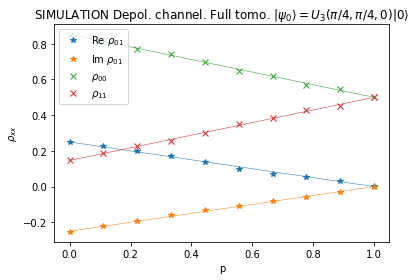

In [9]:
tomo_rhos = np.zeros((2,2,len(p_values)), dtype=complex)

for (i, p) in enumerate(p_values):
    tomo_fitter = StateTomographyFitter(tomography_results[i], tomography_circuits[i])
    tomo_rhos[:,:,i] = tomo_fitter.fit()

# Simulated results
plt.plot(p_values, np.real(tomo_rhos[0,1,:]),"C0*", label='Re $\\rho_{01}$')
plt.plot(p_values, np.imag(tomo_rhos[0,1,:]),"C1*", label='Im $\\rho_{01}$')
plt.plot(p_values, np.real(tomo_rhos[0,0,:]),"C2x", label='$\\rho_{00}$')
plt.plot(p_values, np.real(tomo_rhos[1,1,:]),"C3x", label='$\\rho_{11}$')

# Theoretical prediction

# We obtain the density operator of the initial state
rho0 = partial_trace(DensityMatrix.from_instruction(prepare_state), [0, 1, 3, 4]).data

plt.plot(p_values, np.real(rho0[0,1])*(1-p_values), "C0", linewidth=.5)
plt.plot(p_values, np.imag(rho0[0,1])*(1-p_values), "C1", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[0,0])*(1-p_values), "C2", linewidth=.5)
plt.plot(p_values, 0.5*p_values + np.real(rho0[1,1])*(1-p_values), "C3", linewidth=.5)

plt.xlabel('p')
plt.ylabel('$\\rho_{xx}$')
plt.legend();

plt.title("SIMULATION Depol. channel. Full tomo. $|\\psi_0\\rangle = U_3(\\pi/4,\\pi/4,0)|0\\rangle$");